## Getting MODA Waze Data

MODA gets Waze's crowd sourced traffic data through Waze's Connected Citizens Program. The data feed is in JSON format, and gets updated every 2 minutes. The raw data is stored in Microsoft Azure Storage. 

This notebook shows you how to:
- access the "raw-upload" container in "modawazedata" Azure Storage through their rest API (Azure developer resources here: https://docs.microsoft.com/en-us/rest/api/azure/)
- extract all the filenames of the raw feed in the container
- grab the raw data and save it to a file

Contact Mitsue Iwata, miwata@analytics.nyc.gov, with any questions
Sept 2018

In [2]:
# We have been storing Waze data since June 22nd, 2018. 
# To get an approximation of the number of records stored, we multiply 
# number of weeks * number of days/week * number of hours/day * number of feeds/hour
12 * 7 * 24 * 30

60480

There are roughly 60,480 records from Waze. 

Note, this is a rough approximation. There have been a few short timeframes when the data was not collected 
because of server issues or other hiccups.

## Accessing Azure Storage through REST API

We can call the API to get a list of filenames in a container. However, this only returns 5000 records at a time. Since there is no way to count the number of records, or "blobs", in an Azure container, we will use the approximation from above to loop through our requests in increments of 5000, and use the returned value for "nextmarker" to return the next set of results.


https://docs.microsoft.com/en-us/rest/api/storageservices/list-blobs

### MODA Azure Storage name is: modawazedata
### Container name is: raw-upload



In [3]:
import requests
from bs4 import BeautifulSoup
import lxml
import json
from transform_waze_raw_functions import *

In [4]:
##helper functions
MAXRES_STR = "&maxresults="
MARKER_STR = "&marker="

URL = "https://modawazedata.blob.core.windows.net/raw-upload?restype=container&comp=list&timeout=60"

#build url with max results and next marker
def build_string(max_res, next_marker, url=URL, maxres_str=MAXRES_STR, marker_str=MARKER_STR):
    max_str = maxres_str + str(max_res)
    marker = marker_str + next_marker
    return url + max_str + marker

#make request and soupify
def get_request(url):
    r = requests.get(url)
    c = r.content
    soup = BeautifulSoup(c,'lxml')
    return soup

#generate list of blob names
def make_list_of_blobnames(blob_vals):
    blob_names = []
    for n in blob_vals:
        blob_names.append(n.text)
    return blob_names

#get request and return list of filenames and next marker
def get_filenames_and_marker(soup):
    soup_name = soup.find_all('name')
    
    #generate list of blobnames
    filename_list = make_list_of_blobnames(soup_name)
    
    #get next marker
    marker = soup.find_all('nextmarker')[0].text
    
    return filename_list, marker

#use recursive method with max_results to get all filenames in container 
def get_next_marker_vals(rec_cnt, marker, url, all_blobs):
    if rec_cnt == 0:
        return all_blobs
    else:
        new_url = build_string(rec_cnt, marker, url=url, maxres_str=MAXRES_STR, marker_str=MARKER_STR)
        #print("new URL in recursion ", new_url)
        soup = get_request(new_url)
        blob_list, marker = get_filenames_and_marker(soup)
        all_blobs += blob_list
        print('number of blob filenames ', len(all_blobs))
        rec_cnt = rec_cnt-5000
        print('record count ', rec_cnt)
        
        return get_next_marker_vals(rec_cnt, marker, url, all_blobs)

In [5]:
NUM_RECORDS = 70000 #increments of 5000
MAXRES_STR = "&maxresults="
MARKER_STR = "&marker="

url = "https://modawazedata.blob.core.windows.net/raw-upload?restype=container&comp=list&timeout=60"

#create list object for all blobs names
all_blobs = []

#make first call to url and get the nextmarker value for subsequent calls
s = get_request(url)
blob_list, mark = get_filenames_and_marker(s)
all_blobs += blob_list # add blob names to list

blobnames = get_next_marker_vals(NUM_RECORDS, mark, url, all_blobs)

('number of blob filenames ', 10000)
('record count ', 65000)
('number of blob filenames ', 15000)
('record count ', 60000)
('number of blob filenames ', 20000)
('record count ', 55000)
('number of blob filenames ', 25000)
('record count ', 50000)
('number of blob filenames ', 30000)
('record count ', 45000)
('number of blob filenames ', 35000)
('record count ', 40000)
('number of blob filenames ', 40000)
('record count ', 35000)
('number of blob filenames ', 45000)
('record count ', 30000)
('number of blob filenames ', 50000)
('record count ', 25000)
('number of blob filenames ', 55000)
('record count ', 20000)
('number of blob filenames ', 60000)
('record count ', 15000)
('number of blob filenames ', 65000)
('record count ', 10000)
('number of blob filenames ', 70000)
('record count ', 5000)
('number of blob filenames ', 75000)
('record count ', 0)


In [6]:
print(len(blobnames))
print(len(set(blobnames)))

75000
75000


This code isn't perfect - there looks to be some redundancy, but we have about 60K filenames!

In [7]:
blobnames[:10]

[u'wazeprocessorraw_2018-06-22T20:04:00.3740299Z.json',
 u'wazeprocessorraw_2018-06-22T20:06:00.7231344Z.json',
 u'wazeprocessorraw_2018-06-22T20:08:00.9739038Z.json',
 u'wazeprocessorraw_2018-06-22T20:10:00.6637321Z.json',
 u'wazeprocessorraw_2018-06-22T20:12:00.2506104Z.json',
 u'wazeprocessorraw_2018-06-22T20:14:00.7759341Z.json',
 u'wazeprocessorraw_2018-06-22T20:16:00.2133851Z.json',
 u'wazeprocessorraw_2018-06-22T20:18:00.4600203Z.json',
 u'wazeprocessorraw_2018-06-22T20:20:00.7461843Z.json',
 u'wazeprocessorraw_2018-06-22T20:22:01.1014014Z.json']

## Raw File URL

Now we have to build the url to grab the raw file, then we can write it to a local file.

In [8]:
base_url = "https://modawazedata.blob.core.windows.net/raw-upload/"
blobnames = list(set(blobnames))

file_url_list = []
for b in blobnames:
    file_url_list.append(base_url + b)

file_url_list[:10]

[u'https://modawazedata.blob.core.windows.net/raw-upload/wazeprocessorraw_2018-09-23T10:36:00.2291979Z.json',
 u'https://modawazedata.blob.core.windows.net/raw-upload/wazeprocessorraw_2018-08-22T03:42:01.1570565Z.json',
 u'https://modawazedata.blob.core.windows.net/raw-upload/wazeprocessorraw_2018-07-22T01:40:00.1506695Z.json',
 u'https://modawazedata.blob.core.windows.net/raw-upload/wazeprocessorraw_2018-07-14T18:38:00.9766785Z.json',
 u'https://modawazedata.blob.core.windows.net/raw-upload/wazeprocessorraw_2018-08-04T21:46:00.2605479Z.json',
 u'https://modawazedata.blob.core.windows.net/raw-upload/wazeprocessorraw_2018-09-02T16:18:00.0779936Z.json',
 u'https://modawazedata.blob.core.windows.net/raw-upload/wazeprocessorraw_2018-08-28T23:48:00.7661853Z.json',
 u'https://modawazedata.blob.core.windows.net/raw-upload/wazeprocessorraw_2018-09-11T02:52:00.9846487Z.json',
 u'https://modawazedata.blob.core.windows.net/raw-upload/wazeprocessorraw_2018-06-23T12:22:00.1179374Z.json',
 u'https:/

In [9]:
req = requests.get(file_url_list[1])
data = req.json()
with open('data.json','w') as f:
    json.dump(data,f)
if 'alerts' in data.keys():
    al = pd.DataFrame(data['alerts'])

al

,city,confidence,country,location,magvar,nThumbsUp,pubMillis,reliability,reportDescription,reportRating,roadType,street,subtype,type,uuid
0,"Staten Island, NY",5,US,"{u'y': 40.5885126486, u'x': -74.1937100887}",171,0,1531966160000,10,NaN,0,2.0,NaN,HAZARD_ON_ROAD_CONSTRUCTION,WEATHERHAZARD,45beaa65-7059-3083-a588-f9396881ee4b
1,"Staten Island, NY",5,US,"{u'y': 40.588879285, u'x': -74.1933774948}",171,0,1530827975000,10,NaN,0,2.0,NaN,HAZARD_ON_ROAD_CONSTRUCTION,WEATHERHAZARD,a3510ead-5843-35cd-bb21-7c4555fc053d
2,"Elizabeth, NJ",0,US,"{u'y': 40.684333, u'x': -74.189206}",0,0,1532865805819,6,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,adea3cbb-68ae-3b1e-9243-788cbba9e301
3,"Elizabeth, NJ",1,US,"{u'y': 40.681168, u'x': -74.189309}",0,0,1532865798180,8,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,d382305d-fdba-3a06-860b-7223b3bee940
4,"Elizabeth, NJ",1,US,"{u'y': 40.685938, u'x': -74.188656}",0,0,1532865915029,8,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,1b89ca68-6195-3023-87e0-bf0cf4004f2d
5,"Elizabeth, NJ",0,US,"{u'y': 40.684863, u'x': -74.189072}",0,0,1532865761871,7,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,b24e1b78-69f2-314b-8fd9-db4835f45b2b
6,"Elizabeth, NJ",0,US,"{u'y': 40.681968, u'x': -74.189449}",0,0,1532865711819,6,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,9412e45c-4556-3f54-b8b0-23e19117abde
7,"Elizabeth, NJ",0,US,"{u'y': 40.681085, u'x': -74.191085}",0,0,1532865703096,6,Construction,0,NaN,Basilone Rd,ROAD_CLOSED_EVENT,ROAD_CLOSED,2024e99d-de05-3933-b643-c363c0e1e6cb
8,"Elizabeth, NJ",0,US,"{u'y': 40.685426, u'x': -74.188875}",0,0,1532865793904,6,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,587f0b37-cc35-37f2-8ff7-5c807760c26c
9,"Newark, NJ",1,US,"{u'y': 40.694293, u'x': -74.18095}",0,0,1532865811714,8,Road Closed for Construction,0,NaN,NaN,ROAD_CLOSED_EVENT,ROAD_CLOSED,e5539921-a201-3e8b-86f0-febd0bbcec8f


In [10]:
#al[al.index == range(20)].index
#al_short = al.loc[indices, :]

short_al = al.copy()[0:30]

short_al

,city,confidence,country,location,magvar,nThumbsUp,pubMillis,reliability,reportDescription,reportRating,roadType,street,subtype,type,uuid
0,"Staten Island, NY",5,US,"{u'y': 40.5885126486, u'x': -74.1937100887}",171,0,1531966160000,10,NaN,0,2.0,NaN,HAZARD_ON_ROAD_CONSTRUCTION,WEATHERHAZARD,45beaa65-7059-3083-a588-f9396881ee4b
1,"Staten Island, NY",5,US,"{u'y': 40.588879285, u'x': -74.1933774948}",171,0,1530827975000,10,NaN,0,2.0,NaN,HAZARD_ON_ROAD_CONSTRUCTION,WEATHERHAZARD,a3510ead-5843-35cd-bb21-7c4555fc053d
2,"Elizabeth, NJ",0,US,"{u'y': 40.684333, u'x': -74.189206}",0,0,1532865805819,6,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,adea3cbb-68ae-3b1e-9243-788cbba9e301
3,"Elizabeth, NJ",1,US,"{u'y': 40.681168, u'x': -74.189309}",0,0,1532865798180,8,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,d382305d-fdba-3a06-860b-7223b3bee940
4,"Elizabeth, NJ",1,US,"{u'y': 40.685938, u'x': -74.188656}",0,0,1532865915029,8,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,1b89ca68-6195-3023-87e0-bf0cf4004f2d
5,"Elizabeth, NJ",0,US,"{u'y': 40.684863, u'x': -74.189072}",0,0,1532865761871,7,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,b24e1b78-69f2-314b-8fd9-db4835f45b2b
6,"Elizabeth, NJ",0,US,"{u'y': 40.681968, u'x': -74.189449}",0,0,1532865711819,6,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,9412e45c-4556-3f54-b8b0-23e19117abde
7,"Elizabeth, NJ",0,US,"{u'y': 40.681085, u'x': -74.191085}",0,0,1532865703096,6,Construction,0,NaN,Basilone Rd,ROAD_CLOSED_EVENT,ROAD_CLOSED,2024e99d-de05-3933-b643-c363c0e1e6cb
8,"Elizabeth, NJ",0,US,"{u'y': 40.685426, u'x': -74.188875}",0,0,1532865793904,6,Construction,0,NaN,Earhart Dr,ROAD_CLOSED_EVENT,ROAD_CLOSED,587f0b37-cc35-37f2-8ff7-5c807760c26c
9,"Newark, NJ",1,US,"{u'y': 40.694293, u'x': -74.18095}",0,0,1532865811714,8,Road Closed for Construction,0,NaN,NaN,ROAD_CLOSED_EVENT,ROAD_CLOSED,e5539921-a201-3e8b-86f0-febd0bbcec8f


In [27]:
lat = []
lon = []

for i in range(short_al.shape[0]):
    #print (short_al.loc[i]['location']['y'])
    #print (short_al.loc[i]['location']['x'])
    lat.append(short_al.loc[i]['location']['y'])
    lon.append(short_al.loc[i]['location']['x'])
    #short_al.loc[i]['latitude'] = 3 #short_al.loc[i]['location']['y']
    #short_al.loc[i]['longitude'] = short_al.loc[i]['location']['x']
    #print (short_al.loc[i])
    #print (i)


In [32]:
from mpl_toolkits.basemap import Basemap


[-74.19371008872987, -74.19337749481203, -74.189206, -74.189309, -74.188656, -74.189072, -74.189449, -74.191085, -74.188875, -74.18095, -74.18079, -73.986969, -74.144805, -74.143937, -74.143173, -74.143276, -74.140179, -74.143276, -74.105714, -74.143937, -74.14247989654542, -74.14178252220155, -74.14360642433168, -74.14319872856142, -74.14690017700197, -74.14372444152833, -74.14714694023134, -74.1502368450165, -74.022905, -74.019075]


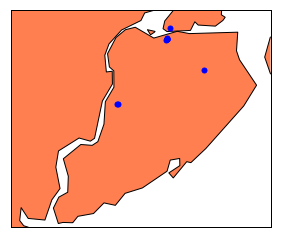

In [31]:
map = Basemap(projection='merc', lat_0 = 40.58, lon_0 = -74.15,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon= -74.301436, llcrnrlat=40.493899,
    urcrnrlon=-74.038946, urcrnrlat=40.660695)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()
 

print (lon)
x,y = map(lon, lat)
map.plot(x, y, 'bo', markersize=5)
 
plt.show()

## potential next step: use shape files from ESRI to be able to plot road maps

Any questions or suggestions, email, miwata@analytics.nyc.gov

In [ ]:
'''
To do:
- How to combine every records with stored filename
- How to add new records from the feed as files are being ETL'd
- How to append new records that come in
'''